- Plot Sentinel-2 RGB images (2023) for all Climate TRACE TOP 20 landfills
- Plot monthly Sentinel-2 images for the Ghabawi and Ghazipur landfills

In [1]:
import os
import pandas as pd
from pystac_client import Client
from odc.stac import load
from shapely import Point
import xarray as xr
import pyproj
from glob import glob
import calendar
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
from matplotlib import rcParams
font_size = 15
rcParams['axes.titlesize'] = font_size - 3
# rcParams['axes.titleweight'] = 'bold'
# rcParams['axes.labelsize'] = font_size - 2
# rcParams['xtick.labelsize'] = font_size - 2
# rcParams['ytick.labelsize'] = font_size - 2
# rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
df = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')

df['plume_mask'] = df[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0

obs_mask = ~(df[['overpass(emit)', 'overpass(enmap)', 'overpass(prisma)']].sum(axis=1) == 0)

# tropomi hotspots with no plume detected by HSI
df['no_plume_mask'] = (df[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) == 0) & obs_mask

## Download S2 images for TOP 20 landfills

In [4]:
# def get_bbox(row, buffer=0.01):
#     if 'longitude' in row.index:
#         point = Point(row['longitude'], row['latitude'])
#         # add the required distance/buffer around the lat lon
#         bbox = point.buffer(buffer).bounds
#     elif 'lon_min' in row.index:
#         bbox = (row['lon_min'], row['lat_min'], row['lon_max'], row['lat_max'])
#     else:
#         raise ValueError('Please make sure you have correct column names')

#     return bbox

# client = Client.open("https://earth-search.aws.element84.com/v1")
# collection = "sentinel-2-l2a"

# def get_img(row, datetime_range='2023-01-01/2023-12-31'):
#     # get one clear image in 2023
#     search = client.search(collections = [collection],
#                             bbox = row['bbox'],
#                             datetime = datetime_range,
#                             query = {"eo:cloud_cover":{"lt":0.03}},
#                             max_items=1,
#                             )
#     data = load(search.items(), bbox=row['bbox'], groupby="solar_day", chunks={})
#     savename = os.path.join('../data/S2_RGB/', row['name'].replace(' ', '_'))+'.nc'
#     print(f'Exporting to {savename}')
#     data[["red", "green", "blue"]].isel(time=0).to_array().rename('rgb').to_netcdf(savename)

# buffer = 0.01
# df['bbox'] = df.apply(get_bbox, buffer=buffer, axis=1)

# df.apply(get_img, axis=1)

## Plot S2 images

In [5]:
def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def corr_rgb(data):
    rgb_gamma = gammacorr(data)
    rgb_corr = normalize(rgb_gamma)
    return rgb_corr

../data/S2_RGB/Bandeirantes.nc


/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/s

../data/S2_RGB/Bisasar.nc
../data/S2_RGB/Chiconautla.nc
../data/S2_RGB/Fyli.nc
../data/S2_RGB/Ghabawi.nc
../data/S2_RGB/Grupo_Contadero_S.A._De_C.V..nc
../data/S2_RGB/Komurcuoda.nc
../data/S2_RGB/Legajny.nc
../data/S2_RGB/Loma_Los_Colorados.nc
../data/S2_RGB/Los_Laureles.nc
../data/S2_RGB/Naameh.nc
../data/S2_RGB/Odayeri.nc
../data/S2_RGB/Relleno_Sanitario.nc
../data/S2_RGB/Relleno_Sanitario_Portezuelos.nc
../data/S2_RGB/Relleno_Sanitario_Puebla.nc
../data/S2_RGB/Simeprodeso.nc
../data/S2_RGB/Sudokwon.nc
../data/S2_RGB/Tehran.nc
../data/S2_RGB/West_New_Territories.nc
../data/S2_RGB/Xingfeng.nc


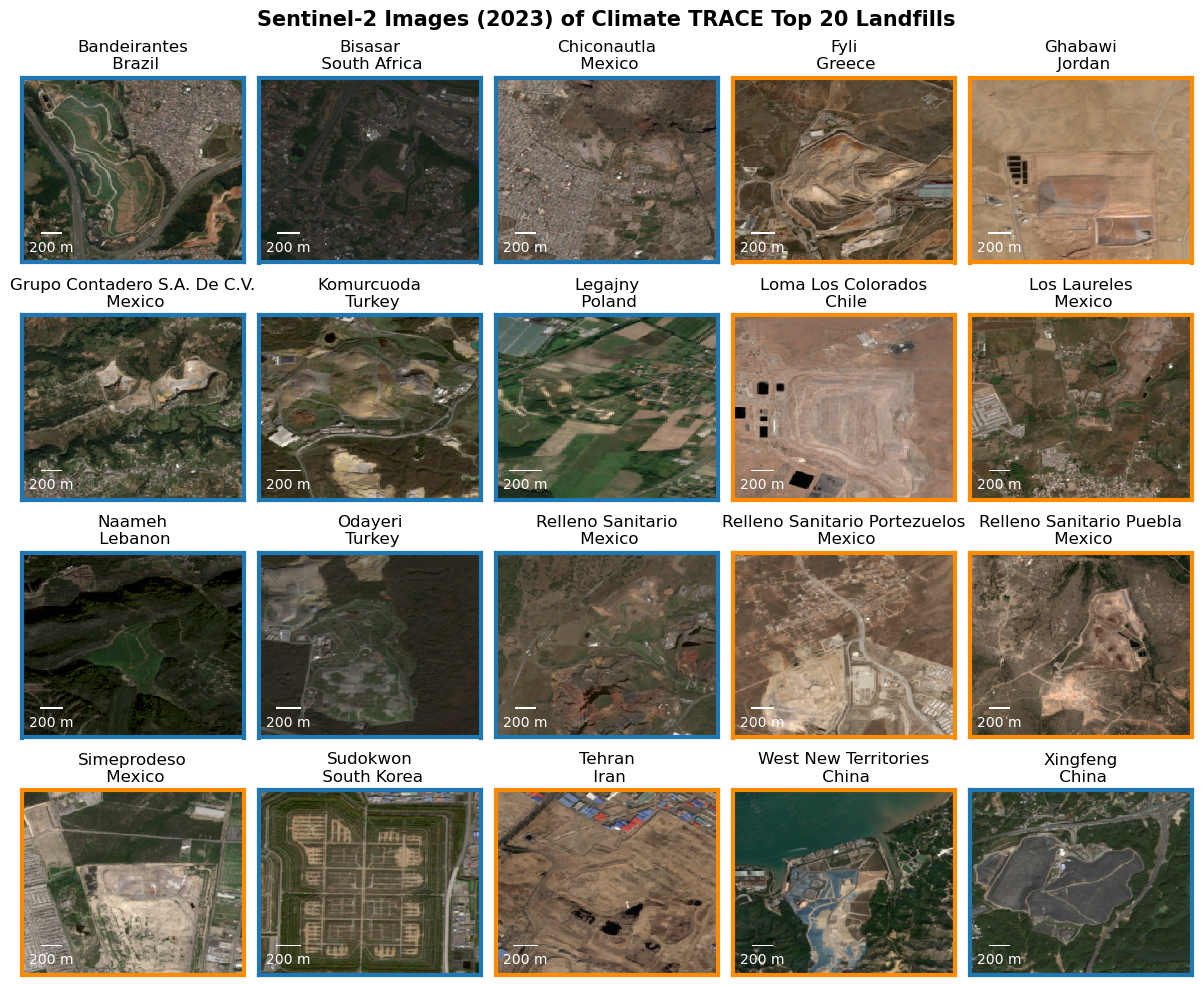

In [6]:
filenames = sorted(glob('../data/S2_RGB/*nc'))

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))

axs = axs.flatten()

for index, filename_rgb in enumerate(filenames):
    name = os.path.basename(filename_rgb.split('.nc')[0].replace('_', ' '))
    print(filename_rgb)

    ds = xr.open_dataset(filename_rgb)
    ax = axs[index]
    rgb_corr = xr.apply_ufunc(corr_rgb,
                              ds['rgb'],
                              input_core_dims=[['y', 'x', 'variable']],
                              output_core_dims=[['y', 'x', 'variable']],
                              vectorize=True,
                              )

    rgb_corr.plot.imshow(ax=ax, rasterized=True)
    data_proj = pyproj.Proj(ds.rio.crs.to_proj4())
    row = df[df['name']==name]
    x, y = data_proj(row['longitude'], row['latitude'])
    # ax.scatter(x, y, marker='*', s=500, facecolors='none', edgecolors='w', linewidths=2)
    ax.set_title(name+f"\n {row['country'].item()}")
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if row['plume_mask'].values:
        spine_color = 'darkorange'
    elif row['no_plume_mask'].values:
        spine_color = 'C0'
    else:
        spine_color = 'darkgray'

    for pos in ['top', 'bottom', 'right', 'left']:
            ax.spines[pos].set_edgecolor(spine_color)
            ax.spines[pos].set(lw=3)

    scalebar = ScaleBar(1, units="m",location='lower left', pad=0.05, border_pad=0.5,
                        frameon=False,color='white')#,length_fraction=0.25)
    ax.add_artist(scalebar)

plt.suptitle('Sentinel-2 Images (2023) of Climate TRACE Top 20 Landfills')

fig.tight_layout()
fig.savefig('../figures/s2_landfills.pdf')

## Download S2 image for two landfills

In [7]:
def get_img_highres(lon, lat, buffer, name, datetime_range='2023-01-01/2023-12-31', period='month', cloud_cover=1):
    point = Point(lon, lat)
    # add the required distance/buffer around the lat lon
    bbox = point.buffer(buffer).bounds

    client = Client.open("https://earth-search.aws.element84.com/v1")
    collection = "sentinel-2-l2a"


    if cloud_cover is None:
        search = client.search(collections = [collection],
                                bbox = bbox,
                                datetime = '2023-01-01/2023-12-31',
                                # max_items=1,
                                )
    else:
        query = {"eo:cloud_cover":{"lt":cloud_cover}}
        search = client.search(collections = [collection],
                                bbox = bbox,
                                datetime = '2023-01-01/2023-12-31',
                                query = query,
                                # max_items=1,
                                )
    data = load(search.items(), bbox=bbox, groupby="solar_day", chunks={})
    savename = os.path.join(f'../data/S2_RGB/{period}/', name)+'.nc'
    print(data)
    print(f'Exporting to {savename}')
    if period in ['month', 'week']:
        data[["red", "green", "blue"]].groupby(f'time.{period}').first().to_array().rename('rgb').to_netcdf(savename)  
    else:
        data[["red", "green", "blue"]].to_array().rename('rgb').to_netcdf(savename)  

In [8]:
# get_img_highres(lon=36.1871, lat=31.928748, buffer=0.01, name='Ghabawi', period='month', cloud_cover=1)
# get_img_highres(lon=77.3274, lat=28.6245, buffer=0.005, name='Ghazipur', period='month', cloud_cover=1)
# get_img_highres(lon=36.1871, lat=31.928748, buffer=0.01, name='Ghabawi', period='all', cloud_cover=1)
# get_img_highres(lon=77.3274, lat=28.6245, buffer=0.005, name='Ghazipur', period='all')

## Plot S2 images

In [9]:
rgb_Ghabawi = xr.open_dataset('../data/S2_RGB/month/Ghabawi.nc')
rgb_Ghazipur = xr.open_dataset('../data/S2_RGB/month/Ghazipur.nc')

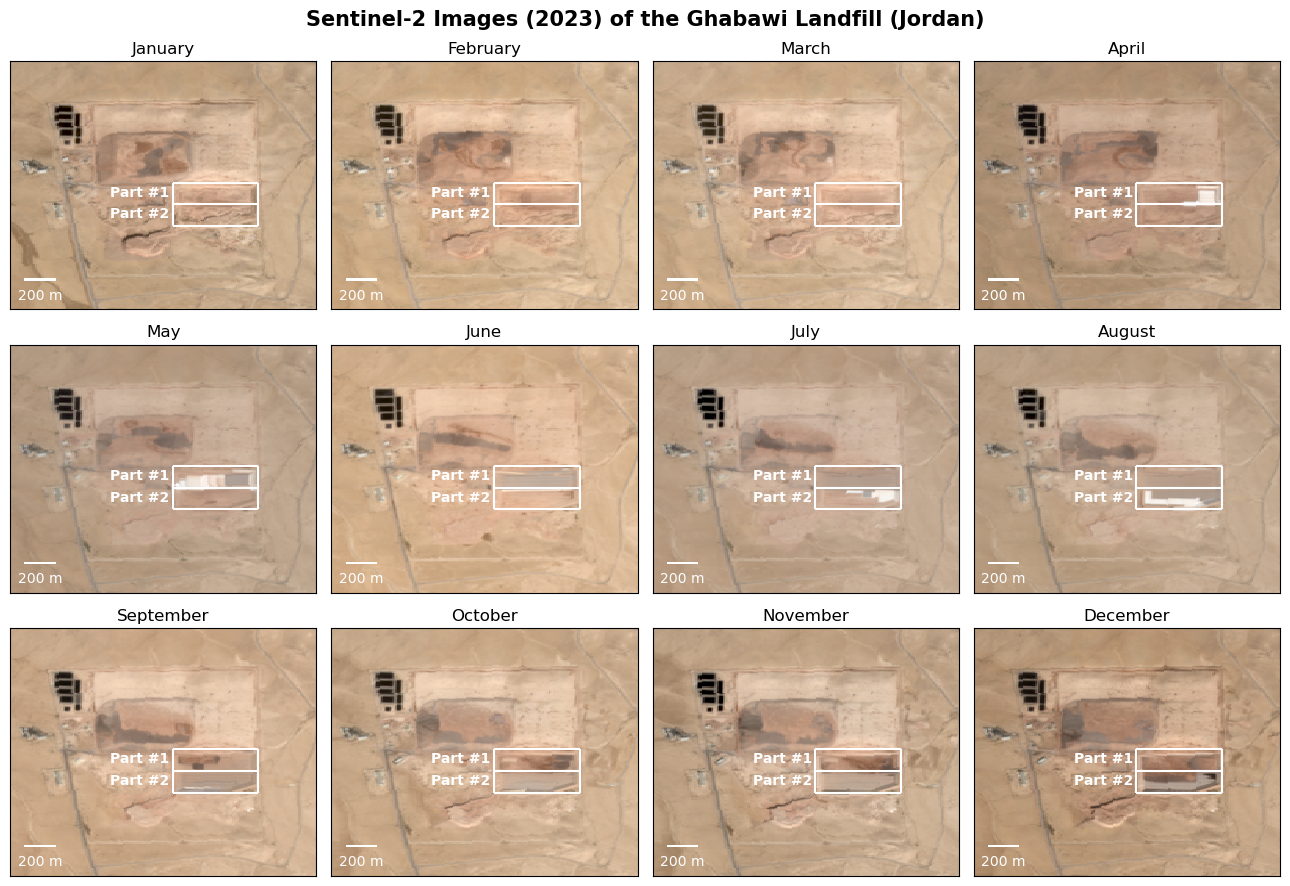

In [10]:
rgb_Ghabawi_corr = xr.apply_ufunc(corr_rgb,
                                  rgb_Ghabawi['rgb'],
                                  input_core_dims=[['y', 'x', 'variable']],
                                  output_core_dims=[['y', 'x', 'variable']],
                                  vectorize=True,
                                  )

g = rgb_Ghabawi_corr.plot.imshow(x="x", y="y", col="month", col_wrap=4, rasterized=True)
# g = rgb_Ghabawi['rgb'].plot.imshow(x="x", y="y", col="month", col_wrap=4, robust=True, rasterized=True)

for i, ax in enumerate(g.axs.flat):
    ax.set_title(calendar.month_name[rgb_Ghabawi['rgb'].month[i].item()])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.vlines(x=[801400, 801950], ymin=3.5366e6, ymax=3.5370e6, colors='w')
    ax.hlines(y=[3.5366e6, 3.5368e6, 3.5370e6], xmin=801400, xmax=801950, colors='w')
    ax.text(801000, 3.53688e6, 'Part #1', c='w', fontweight='bold')
    ax.text(801000, 3.53668e6, 'Part #2', c='w', fontweight='bold')
    scalebar = ScaleBar(1, units="m",location='lower left',pad=0.05,border_pad=0.5,frameon=False,color='white')
    ax.add_artist(scalebar)

plt.suptitle('Sentinel-2 Images (2023) of the Ghabawi Landfill (Jordan)')
plt.tight_layout()
plt.savefig('../figures/s2_tseries_Ghabawi.pdf')

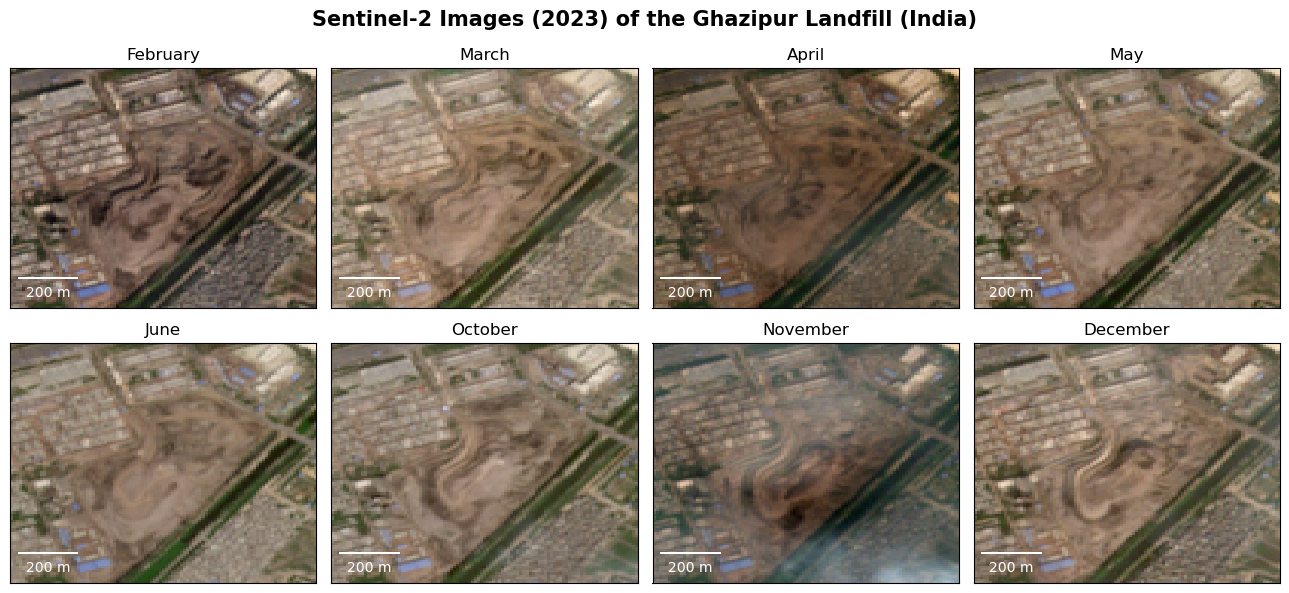

In [11]:
rgb_Ghazipur_corr = xr.apply_ufunc(corr_rgb,
                                  rgb_Ghazipur['rgb'],
                                  input_core_dims=[['y', 'x', 'variable']],
                                  output_core_dims=[['y', 'x', 'variable']],
                                  vectorize=True,
                                  )

g = rgb_Ghazipur_corr.plot.imshow(x="x", y="y", col="month", col_wrap=4, rasterized=True)
# g = rgb_Ghazipur['rgb'].plot.imshow(x="x", y="y", col="month", col_wrap=4, robust=True, rasterized=True)

for i, ax in enumerate(g.axs.flat):
    ax.set_title(calendar.month_name[rgb_Ghazipur['rgb'].month[i].item()])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    scalebar = ScaleBar(1, units="m",location='lower left',pad=0.05,border_pad=0.5,frameon=False,color='white')
    ax.add_artist(scalebar)

plt.suptitle('Sentinel-2 Images (2023) of the Ghazipur Landfill (India)')
plt.tight_layout()
plt.savefig('../figures/s2_tseries_Ghazipur.pdf')